In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
from buildingspy.io.outputfile import Reader

In [5]:
from ipypublish import nb_setup

In [6]:
pd = nb_setup.setup_pandas()

In [7]:
# https://stackoverflow.com/a/39566040/11552622
rcparams = {
    'axes.titlesize':13,
    'axes.labelsize':9,
    'xtick.labelsize':8,
    'ytick.labelsize':8
}

In [8]:
# IPyPublish customization of matplotlib.pyplot and pandas
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib(output=('pdf','svg'), rcparams=rcparams)

# Latex generator

## Simulation data generation

### Parameter range

In [9]:
cols = [r'$E_{max,lv}$', r'$E_{max,lv,0}$',
                  r'$G_{E_{max,lv}}$', r'$k_{E,lv}$']
index = ['Lower bound', 'Upper bound']
data = np.array([
    [0.2, 2.95],
    [0.2, 2.392],
    [0.2, 0.475],
    [0.011, 0.014]
]).transpose()

In [10]:
pd.DataFrame(data=data, index=index, columns=cols)

,"$E_{max,lv}$","$E_{max,lv,0}$","$G_{E_{max,lv}}$","$k_{E,lv}$"
Lower bound,0.20,0.200,0.200,0.011
Upper bound,2.95,2.392,0.475,0.014


# Get a visual

## Normalization

In [11]:
import sys
import scipy.io as sio

In [12]:
sys.path.insert(0, '../Simulation_script/')

In [13]:
%run ../Deep_learning/utils_deeplearning.py

In [14]:
X = sio.loadmat('/media/maousi/Data/tmp/dnntest/X.mat')['X']

In [15]:
X.shape

(10000, 2, 667)

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ -2.68846109,  16.39339264,  35.47524638,  54.55710011,
         73.63895385,  92.72080758, 111.80266132, 130.88451506,
        149.96636879, 169.04822253, 188.13007626]),
 <a list of 10 Patch objects>)

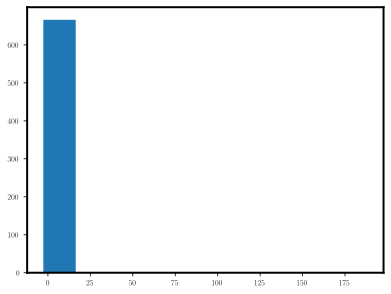

In [16]:
plt.hist(X[0, 0])

In [17]:
ncoeff, nfreq = X.shape[1], X.shape[2]

In [18]:
newmins = np.full([ncoeff, nfreq], 0.0)
newmaxs = np.full([ncoeff, nfreq], 1.0)

In [19]:
%%capture cap_out
Xnorm, _, _ = normalizeinputmatDL(X, newmins, newmaxs);

(array([  4.,   5.,  21.,  77., 153., 192., 126.,  68.,  13.,   8.]),
 array([0.07757032, 0.16784601, 0.2581217 , 0.34839739, 0.43867309,
        0.52894878, 0.61922447, 0.70950016, 0.79977586, 0.89005155,
        0.98032724]),
 <a list of 10 Patch objects>)

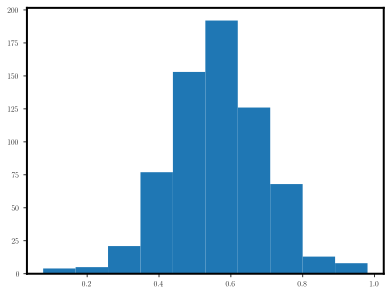

In [20]:
plt.hist(Xnorm[0, 0])

# Figures



## SHF simulations

In [21]:
sns.set(style='whitegrid')

In [62]:
# Define: variables to load
variables = ['SystemicArteries.PC', 'AorticValve.Inlet.Q',
             'SystemicArteries.Inlet.Q', 'LVAD.RPM', 'LeftVentricle.Inlet.P']
# Define folder
folder_standalone_sim = '/media/maousi/Data/tmp/standalone_simulations/'

In [23]:
# Data structure: nested dictionnaries
# level 1 = heart failure, level 2 = rpm
data_sim = {
    hf_level: {rpm: None for rpm in [4000, 5000, 6000]}
    for hf_level in ['MHF', 'SHF']
}

In [24]:
def time_range(tmin, tmax, t, signal):
    ids = np.where(np.logical_and(t >= tmin, t <= tmax))
    return t[ids], signal[ids]

def read_simulations(path, file_format, data, variables, tmin, tmax):
    for hf_level, subdata in data.items():
        for rpm in subdata:
            file = path + file_format.format(hf_level, rpm)
            reader = Reader(file, 'dymola')
            subdata[rpm] = [
                time_range(tmin, tmax, *reader.values(v)) for v in variables
            ]

In [63]:
read_simulations(
    path=folder_standalone_sim, file_format='Ursino1998Model_VAD2_{}_{}.mat',
    data=data_sim, variables=variables, tmin=20.0, tmax=30.0
)

In [64]:
data_sim['SHF'][4000]

[(array([20.        , 20.        , 20.00424609, ..., 30.        ,
         30.        , 30.        ]),
  array([74.08635286, 74.08635286, 76.62318061, ..., 72.66994084,
         72.66994084, 72.66994084])),
 (array([20.        , 20.        , 20.00424609, ..., 30.        ,
         30.        , 30.        ]),
  array([0., 0., 0., ..., 0., 0., 0.])),
 (array([20.        , 20.        , 20.00424609, ..., 30.        ,
         30.        , 30.        ]),
  array([  0.        , 178.95      , 178.95      , ...,   6.67708677,
         178.95      , 178.95      ])),
 (array([20.        , 20.        , 20.00424609, ..., 30.        ,
         30.        , 30.        ]),
  array([4000., 2000., 2000., ..., 4000., 2000., 2000.])),
 (array([20.        , 20.        , 20.00424609, ..., 30.        ,
         30.        , 30.        ]),
  array([12.77283544, 12.77283544, 12.8931806 , ..., 16.24197913,
         16.24197913, 16.24197913]))]

In [92]:
# We have 2 heart failure levels * 3 rpm levels = 6 simulations
# The function handles data for a given heart failure level
def plot_simulations(data_hf):
    fig, ax = plt.subplots(len(data_hf), 1, figsize=(10, 10))

    for i, (rpm_c, data) in enumerate(data_hf.items()):
        ax1 = ax[i]
        ax2 = ax1.twinx()

        (t1, pressure), (t2, valve_flow), (t3, aortic_flow), (t4, rpm), (t5, lv_pressure) = data
        #(t1, pressure), (t2, valve_flow), (t3, arotic_flow), (t4, rpm) = data[0], data[1], data[2], data[3]
        ax1.plot(t4, rpm/100, 'k--', linewidth=1)
        ax1.plot(t1, pressure, 'b')
        ax1.plot(t1, lv_pressure, '--', linewidth=0.5)
        ax2.plot(t2, valve_flow, 'g--', linewidth=1)
        ax2.plot(t3, aortic_flow, 'r')
        #ax2.set_ylim([min(flow)-25, max(flow)+25])
        #ax1.set_ylim(-5, max(max(pressure), max(flow)))
        #ax2.plot(t2, flow)

        # Manage x axis
        if i == 2:
            ax1.set_xlabel('Time [s]')
        else:
            pass#ax1.set_xticks([])
        
        ax1.set_ylabel('Systemic pressure [mmHg]\nLV pressure [mmHg]\nPump speed [RPM/100]')
        ax2.set_ylabel('Aortic flow [ml/s]\nValve flow [ml/s]')
        #ax1.yaxis.label.set_color('b')
        # Align the grids
        #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
        ax2.grid(False)
        ax2.set_ylim([-5, 1.5*max(aortic_flow)])
        #ax1.set_title('RPM mean = {}'.format(rpm_c))

    plt.subplots_adjust(hspace=.2)

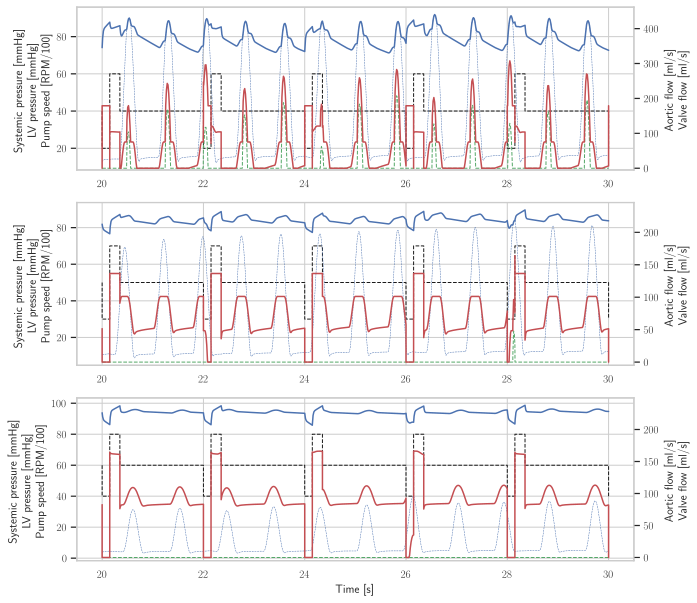

In [93]:
plot_simulations(data_sim['SHF'])
plt.savefig('figs/SHF_simulations.eps')

### Compare pressure 


### Compute metrics

In [28]:
shf = data_sim['SHF']

In [29]:
# get_sap returns (t, pressure)
get_sap = lambda datastruct, rpm: datastruct[rpm][0]

In [30]:
# Mean SAP


## DNN accuarcy

### Effect of artificial pulse

In [31]:
Ymse = pickle.load(open('data/dnn_mse.bin', 'rb'))

In [32]:
Ymse

Parameter                  Emax     Emax0    G_Emax           k_E
RPM  Artificial Pulse                                            
0    False             0.008973  0.007464  0.001996  2.603902e-08
4000 False             0.011211  0.006052  0.001854  1.250480e-08
     True              0.028027  0.009336  0.005369  2.320466e-08
5000 False             0.014051  0.007078  0.002771  2.662316e-08
     True              0.039225  0.012941  0.003403  4.527304e-08
6000 False             0.008550  0.003071  0.000826  2.915873e-08
     True              0.026556  0.004619  0.002180  1.755126e-08

In [33]:
Ymse.index

MultiIndex([(   0, False),
            (4000, False),
            (4000,  True),
            (5000, False),
            (5000,  True),
            (6000, False),
            (6000,  True)],
           names=['RPM', 'Artificial Pulse'])

In [34]:
YmseT = Ymse.transpose()
YmseT

RPM                       0             4000                        5000  \
Artificial Pulse         False         False         True          False   
Parameter                                                                  
Emax              8.972837e-03  1.121134e-02  2.802725e-02  1.405068e-02   
Emax0             7.464042e-03  6.052479e-03  9.335520e-03  7.077843e-03   
G_Emax            1.995823e-03  1.854373e-03  5.368810e-03  2.771385e-03   
k_E               2.603902e-08  1.250480e-08  2.320466e-08  2.662316e-08   

RPM                                     6000                
Artificial Pulse         True          False         True   
Parameter                                                   
Emax              3.922518e-02  8.550243e-03  2.655583e-02  
Emax0             1.294064e-02  3.071437e-03  4.619114e-03  
G_Emax            3.403093e-03  8.264770e-04  2.180478e-03  
k_E               4.527304e-08  2.915873e-08  1.755126e-08

In [35]:
rpms = [4000, 5000, 6000]
columns = pd.Index(name='RPM', data=rpms)
artpulse_error = pd.DataFrame(columns=columns, index=YmseT.index)
for rpm in rpms:
    # Compute MSE relative increase of each param for each rpm
    percincrease = (YmseT[(rpm, True)] - YmseT[(rpm, False)])/YmseT[(rpm, False)] * 100
    artpulse_error.loc[:, rpm] = percincrease

In [36]:
artpulse_error

RPM,4000,5000,6000
Parameter,,,
Emax,149.990174,179.169256,210.585691
Emax0,54.242909,82.833055,50.389333
G_Emax,189.521491,22.793948,163.828027
k_E,85.566132,70.051354,-39.807884


In [37]:
artpulse_error.apply(np.mean, axis=1)

Parameter
Emax      179.915040
Emax0      62.488432
G_Emax    125.381156
k_E        38.603201
dtype: float64

### Effect of LVAD presence

In [38]:
Ymse.drop((0, False)).apply(np.mean)

Parameter
Emax      2.127009e-02
Emax0     7.182838e-03
G_Emax    2.734103e-03
k_E       2.571927e-08
dtype: float64

## HEmodynamic quantities

In [39]:
X = pd.read_csv('data/hemodynamic_test_data.csv')

In [40]:
X

,HR,SAPM,SAPS,SAPD,PAPM,PAPS,PAPD,LVEF,LVEDV,LVESV,...,PAPM_hat,PAPS_hat,PAPD_hat,LVEF_hat,LVEDV_hat,LVESV_hat,CI_hat,PCPW_hat,RPM,art_pulse
0,65.217391,90.853600,122.580232,74.990285,18.246077,29.196520,12.770856,58.166914,142.949517,59.800194,...,18.117516,28.990198,12.681175,58.834069,141.975938,58.445716,2.063254,8.682431,4000,False
1,62.500000,94.702502,126.595962,78.755773,16.719180,27.999919,11.078811,57.531861,158.079150,67.133273,...,16.661273,28.008215,10.987803,58.473456,156.194928,64.862356,2.123285,6.812085,4000,False
2,65.217391,92.609776,126.435978,75.696675,18.193093,29.000448,12.789416,54.782405,149.250685,67.487571,...,18.172884,28.960065,12.779293,54.440236,150.272467,68.463782,2.193700,8.471282,4000,False
3,62.500000,93.788953,126.441664,77.462598,17.356856,28.540265,11.765151,58.570209,148.720360,61.614534,...,17.189097,28.380363,11.593464,58.966211,149.551618,61.366695,2.050003,7.449523,4000,False
4,62.500000,94.978545,128.960053,77.987791,17.525749,28.486615,12.045316,53.208741,162.688402,76.123951,...,17.490663,28.581349,11.945319,54.271334,161.837829,74.006280,2.237018,7.393110,4000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,69.490717,93.456844,108.760781,85.804876,13.948959,25.755606,8.045635,60.591265,100.597833,39.644334,...,13.951465,25.757933,8.048231,59.923764,100.114005,40.121925,0.221801,3.237311,6000,True
3496,68.965517,91.272495,103.406873,85.205306,14.345969,25.926282,8.555812,58.167093,97.376392,40.735375,...,14.247574,25.909351,8.416686,56.763769,95.549587,41.312040,0.137171,3.628000,6000,True
3497,70.001125,95.298143,112.014718,86.939856,13.786635,25.695602,7.832152,68.128147,98.478002,31.386764,...,13.774736,25.695330,7.814438,69.000366,98.092437,30.408297,0.325756,3.012160,6000,True
3498,63.492063,89.436247,99.403701,84.452520,14.889113,26.152609,9.257364,57.425292,109.132181,46.462708,...,14.891645,26.154932,9.260001,57.522840,108.705584,46.175045,0.000000,4.407377,6000,True


In [41]:
X.columns

Index(['HR', 'SAPM', 'SAPS', 'SAPD', 'PAPM', 'PAPS', 'PAPD', 'LVEF', 'LVEDV',
       'LVESV', 'CI', 'PCPW', 'HR_hat', 'SAPM_hat', 'SAPS_hat', 'SAPD_hat',
       'PAPM_hat', 'PAPS_hat', 'PAPD_hat', 'LVEF_hat', 'LVEDV_hat',
       'LVESV_hat', 'CI_hat', 'PCPW_hat', 'RPM', 'art_pulse'],
      dtype='object')

In [42]:
# Relative errors
E = X.loc[:, ['RPM', 'art_pulse'] + [col for col in X.columns if '_relerr' in col]]

In [43]:
E

,RPM,art_pulse
0,4000,False
1,4000,False
2,4000,False
3,4000,False
4,4000,False
...,...,...
3495,6000,True
3496,6000,True
3497,6000,True
3498,6000,True


### Mean relative errors

In [44]:
E = E.groupby(['RPM', 'art_pulse']).mean().rename({
    col: col.split('_')[0] for col in E.columns[2:]
}, axis=1)

DataError: No numeric types to aggregate

In [ ]:
E.index.rename(['RPM', 'Art. Pulse'], inplace=True)

In [ ]:
pd.set_option('precision', 2)

In [ ]:
E

### Mean

In [ ]:
Xmean = X.loc[:, [c for c in X.columns if '_relerr' in c]].mean()
Xmean

### Median

In [ ]:
Xmed = X.loc[:, [c for c in X.columns if '_relerr' in c]].median()
Xmed

In [ ]:
pd.DataFrame([Xmean, Xmed]).transpose().rename({0:'Mean', 1:'Median'}, axis=1)

### Describe

In [ ]:
X.loc[:, [c for c in X.columns if '_relerr' in c]].describe().transpose()

### Effect of artificial pulse

In [ ]:
AP_data_ = E.drop('CI', axis=1).drop((0, False))
AP_data_

In [ ]:
AP_data = pd.DataFrame(index=AP_data_.columns)
for rpm in [4000,5000,6000]:
    diff = AP_data_.loc[(rpm, True), :] - AP_data_.loc[(rpm, False), :]
    AP_data[rpm] = diff / AP_data_.loc[(rpm, True), :] * 100

In [ ]:
AP_data

In [ ]:
AP_data.mean()

### Effet of RPMs when artificial pulse is active

In [ ]:
RPM = X.loc[X.art_pulse == True, ['RPM'] + [c for c in X.columns if '_relerr' in c]].groupby('RPM').mean()
RPM

### Effect of RPM when artificial pulse is NOT active

In [ ]:
RPM = X.loc[X.art_pulse == False, ['RPM'] + [c for c in X.columns if '_relerr' in c]].groupby('RPM').mean()
RPM